In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import glob
import random
from collections import defaultdict
from pathlib import Path

from IPython.display import display
import numpy as np
import pandas as pd

from tqdm import tqdm
import jax
jax.config.update('jax_platform_name', 'gpu')

In [2]:
# !pip install PyDMD

In [3]:
sys.path.append("..")

from lib import utils as U
from lib.ehr.dataset import load_dataset

In [4]:
# Assign the folder of the dataset to `DATA_FILE`.

HOME = os.environ.get('HOME')
DATA_DIR = f'{HOME}/GP/ehr-data'
SOURCE_DIR = os.path.abspath("..")

In [5]:

output_dir = 'mimic_artefacts'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [6]:
with U.modified_environ(DATA_DIR=DATA_DIR):
    m3_dataset = load_dataset('M3')
    m4_dataset = load_dataset('M4')
   

                Unrecognised <class 'lib.ehr.coding_scheme.DxICD9'> codes (38)
                to be removed: ['041.49', '282.40', '282.46', '284.11', '284.12', '284.19', '294.20', '294.21', '348.82', '365.70', '425.11', '425.18', '444.09', '512.83', '512.84', '512.89', '516.31', '516.34', '516.36', '518.51', '518.52', '518.53', '573.5', '596.89', '719.70', '747.32', '793.11', '793.19', '795.51', '997.49', '998.01', '998.09', '999.32', '999.33', 'V12.55', 'V13.89', 'V54.82', 'V88.21']
                Unrecognised <class 'lib.ehr.coding_scheme.PrICD9'> codes (7)
                to be removed: ['02.21', '17.55', '17.56', '35.05', '36.01', '36.02', '36.05']
                    Unrecognised <class 'lib.ehr.coding_scheme.DxICD10'> codes (4178)
                    to be removed: ['E10.3213', 'E10.3219', 'E10.3291', 'E10.3292', 'E10.3293', 'E10.3299', 'E10.3312', 'E10.3313', 'E10.3391', 'E10.3393', 'E10.3399', 'E10.3411', 'E10.3413', 'E10.3491', 'E10.3492', 'E10.3511', 'E10.3512', 'E10.3513',

                    Unrecognised <class 'lib.ehr.coding_scheme.DxICD9'> codes (127)
                    to be removed: ['041.49', '173.01', '173.21', '173.22', '173.30', '173.31', '173.32', '173.39', '173.41', '173.42', '173.49', '173.50', '173.51', '173.52', '173.59', '173.60', '173.61', '173.62', '173.69', '173.71', '173.72', '173.79', '173.80', '173.81', '173.82', '173.91', '173.92', '173.99', '282.40', '282.43', '282.44', '282.46', '284.11', '284.12', '284.19', '286.52', '286.59', '294.20', '294.21', '310.81', '310.89', '331.6', '348.82', '358.30', '365.70', '365.71', '365.72', '365.73', '365.74', '379.27', '414.4', '415.13', '425.11', '425.18', '444.09', '488.81', '488.82', '488.89', '508.2', '512.2', '512.81', '512.82', '512.83', '512.84', '512.89', '516.31', '516.32', '516.33', '516.34', '516.36', '516.37', '516.5', '518.51', '518.52', '518.53', '539.01', '539.09', '539.89', '573.5', '596.81', '596.82', '596.83', '596.89', '629.31', '629.32', '631.0', '631.8', '649.81', '704.41'

In [7]:
from lib.ehr.coding_scheme import DxCCS, DxFlatCCS, DxICD9, DxICD10
from lib.ehr import Subject_JAX
from lib.ehr import StaticInfoFlags

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from lib.ehr import OutcomeExtractor, SurvivalOutcomeExtractor
outcome_class = SurvivalOutcomeExtractor

In [9]:
code_scheme = {
    'dx': DxCCS(), # other options 
    'outcome': SurvivalOutcomeExtractor('dx_flatccs_filter_v1')
}

In [10]:
static_info_flags = StaticInfoFlags(gender=True, age=True)

m3_interface = Subject_JAX.from_dataset(m3_dataset, 
                                        code_scheme=code_scheme, 
                                        static_info_flags=static_info_flags,
                                       data_max_size_gb=1)
m4_interface = Subject_JAX.from_dataset(m4_dataset, 
                                        code_scheme=code_scheme, 
                                        static_info_flags=static_info_flags,
                                       data_max_size_gb=1)


                            S - M_domain (2497, p=0.14371223021582732):
                            ['001', '002', '003', '003.2', '004']...

                            M_domain - S (0, p=0.0):
                            []...

                            M_domain (14878):
                            ['001.0', '001.1', '001.9', '002.0', '002.1']...

                            S (17375): ['001', '001.0', '001.1', '001.9', '002']...

                            S - M_domain (2497, p=0.14371223021582732):
                            ['001', '002', '003', '003.2', '004']...

                            M_domain - S (0, p=0.0):
                            []...

                            M_domain (14878):
                            ['001.0', '001.1', '001.9', '002.0', '002.1']...

                            S (17375): ['001', '001.0', '001.1', '001.9', '002']...
                            dx_icd10->dx_icd9 Unrecognised t_codes
                            (169):
                    

In [11]:

def subject_outcome_acquisition_sequence(interface, subject_adms, resolution=7):
    current_time = resolution
    X = [subject_adms[0].outcome[0]]
    for adm in subject_adms[1:]:
        new_outcome = np.maximum(X[-1], adm.outcome[0])
        if adm.admission_time <= current_time:
            X[-1] = new_outcome
            continue

        while current_time < adm.admission_time:
            current_time += resolution
            X.append(new_outcome)

    return X

def outcome_acquisition_sequence(interface, resolution=7):
    return {
        i: subject_outcome_acquisition_sequence(interface, adms, resolution)
        for i, adms in interface.items()
    }

def outcome_acquisition_transition(interface, resolution=7):
    sequence = outcome_acquisition_sequence(interface, resolution)
    X_prev, X_next = [], []
    for i, seq in sequence.items():
        X_prev.extend(seq[:-1])
        X_next.extend(seq[1:])
    return X_prev, X_next, sequence

In [51]:
X_prev, X_next, ack_seq = outcome_acquisition_transition(m3_interface, 30)
X_prev = np.stack(X_prev, axis=1)
X_next = np.stack(X_next, axis=1)

In [45]:
X_prev.shape

(241, 48227)

In [28]:
from pydmd import MrDMD
from pydmd import DMD
from pydmd import DMDBase
from pydmd.snapshots import Snapshots
from pydmd.utils import compute_tlsq
from pydmd.plotter import plot_eigs

In [25]:
class BatchDMD(DMD):
    def fit(self, X_prev, X_next):
        """
        Compute the Dynamic Modes Decomposition to the input data.

        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        """
        self._reset()

        self._snapshots_holder = Snapshots(X_prev)

        n_samples = self.snapshots.shape[1]

        X, Y = compute_tlsq(X_prev, X_next, self._tlsq_rank)
        self._svd_modes, _, _ = self.operator.compute_operator(X_prev, X_next)

        # Default timesteps
        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )

        self._b = self._compute_amplitudes()

        return self
    
    
   

In [ ]:
import matplotlib.pyplot as plt

def make_plot(X, figsize=(12, 8), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    x = np.linspace(0, X.shape[1], X.shape[1])
    t = np.linspace(0, X.shape[0], X.shape[0])
    X = np.real(X)
    CS = plt.pcolor(x, t, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('Space')
    plt.ylabel('Time')
    plt.show()

    


make_plot(X_prev.T)

In [83]:

first_dmd = BatchDMD(svd_rank=100, opt=True, sorted_eigs='abs', tikhonov_regularization=1e-3)
first_dmd.fit(1-X_prev, 1-X_next)

/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 3.2779146251288478e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/pydmd/plotter.py:188: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f04f6561130>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


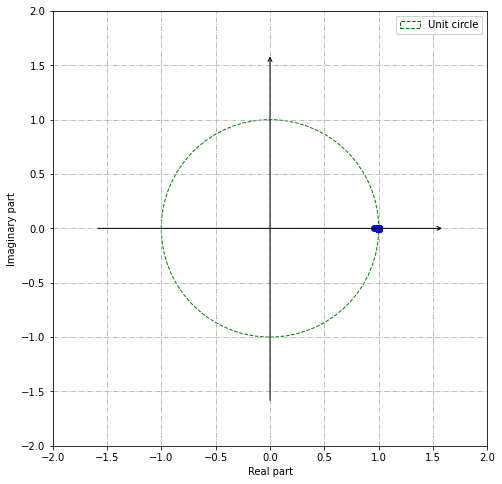

In [84]:
plot_eigs(first_dmd, show_axes=True, show_unit_circle=True)

In [85]:
X_next_recons = first_dmd.predict(1-X_prev)
X_next_recons.shape

(241, 98396)

In [86]:
constant_one_mask = (X_prev == X_next) & (X_prev == 1)
constant_zero_mask = (X_prev == X_next) & (X_prev == 0)
transition_mask = X_prev != X_next
freq = np.mean(1-X_next, axis=1)


np.mean(constant_one_mask), np.mean(constant_zero_mask), np.mean(transition_mask)

(0.059956684472043616, 0.9389886391832883, 0.0010546763446680609)

In [87]:
error = np.abs((1-X_next) - X_next_recons.real)
transition_error = np.sum(transition_mask * error, axis=1) / np.sum(transition_mask, axis=1)
transition_error
# mean_transition_error = np.mean(, axis=1)
# error

/tmp/ipykernel_40736/2007729807.py:2: RuntimeWarning: invalid value encountered in true_divide
  transition_error = np.sum(transition_mask * error, axis=1) / np.sum(transition_mask, axis=1)


array([0.95239106, 0.93021482, 0.9896749 , 0.98374638, 0.92629265,
       0.99110908, 0.97374669, 0.98965547, 0.98156136, 0.99232134,
       0.98049379, 0.98932519, 0.97089536, 0.99386126, 0.91683727,
       0.98353221, 0.9869031 , 0.98617444, 0.99538034, 0.9616531 ,
       0.98962668, 0.99158128, 0.98832829, 0.97132524, 0.92732184,
       0.9773933 , 0.98695669, 0.94797335, 0.98323656, 0.94900124,
       0.94694831, 0.99203085, 0.99199562, 0.98904357, 0.98249112,
       0.99153949, 0.98381214, 0.97340614, 0.99308948, 0.98859995,
       0.98888705, 0.99030125, 0.99076057, 0.9889375 , 0.985753  ,
       0.97714189, 0.99066715, 0.98013868, 0.98851698, 0.99117625,
       0.94979981, 0.99009815, 0.99360864, 0.9556814 , 0.95742155,
       0.99114848, 0.9385403 , 0.99050109, 0.97933628, 0.98994892,
       0.94472798, 0.98828808, 0.97185561, 0.98020398, 0.97842053,
       0.98824153, 0.90583777, 0.93614496, 0.98926592, 0.92735361,
       0.99065757, 0.98922522, 0.98474567, 0.98121627, 0.98515

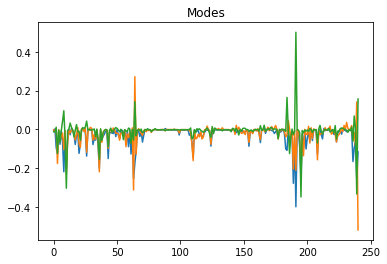

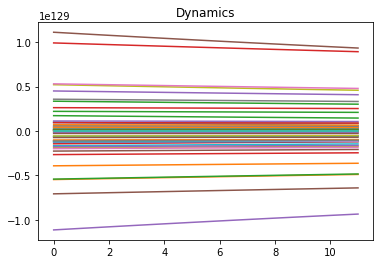

In [89]:
import matplotlib.pyplot as plt

for mode in first_dmd.modes.T[:3]:
    plt.plot(mode.real)
    plt.title("Modes")
plt.show()

for dynamic in first_dmd.dynamics:
    plt.plot(dynamic.real[:12])
    plt.title("Dynamics")
plt.show()

